In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.stats.diagnostic import acorr_ljungbox

# Importación robusta de coint_johansen y kpss
try:
    from statsmodels.tsa.vector_ar.util import coint_johansen
except ImportError:
    try:
        from statsmodels.tsa.stattools import coint_johansen
    except ImportError:
        try:
            from statsmodels.tsa.vector_ar.vecm import coint_johansen
        except ImportError:
            print("Warning: coint_johansen not found. Will implement basic cointegration test.")
            coint_johansen = None

try:
    from statsmodels.tsa.stattools import kpss
except ImportError:
    print("Warning: kpss not available in this statsmodels version")
    kpss = None

import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
try:
    sns.set_palette("husl")
except:
    pass

# DataFrame indicadores
df_indicadores = pd.read_csv('../data/indicadores/indicadores_macroeconomicos.csv',
                             sep=';', encoding='latin1')
df_indicadores = df_indicadores.set_index('fecha')
# CONVERTIR EL ÍNDICE A STRING
df_indicadores.index = df_indicadores.index.astype(str)
df_indicadores.index.name = 'fecha'

# DataFrame termotrade  
df_termotrade = pd.read_csv('../data/indicadores/monthly_results_brazil.csv', 
                            sep=";", encoding='latin1')
df_termotrade = df_termotrade[['date', 'ctot_level']]
df_termotrade = df_termotrade.rename(columns={'ctot_level': 'termoftrade'})
df_termotrade = df_termotrade.set_index('date')
df_termotrade.index = pd.to_datetime(df_termotrade.index).strftime('%Y%m')
df_termotrade.index.name = 'fecha'


# Hacer el merge de los dos DataFrames
df_combined = df_indicadores.join(df_termotrade, how='outer')


gdp_brazil = pd.read_csv('../data/QGDP/brazil.csv', sep =",", encoding='latin1')
gdp_brazil = gdp_brazil.set_index(gdp_brazil.columns[0])
gdp_brazil.index = pd.to_datetime(gdp_brazil.index).strftime('%Y%m')  # String YYYYMM

gdp_brazil = gdp_brazil.rename(columns={gdp_brazil.columns[0]: 'GDP_BRAZIL'})

In [19]:


class TalviVECMModel:
    """
    Implementación del modelo VECM de Izquierdo, Romero y Talvi (2008)
    "Booms and Busts in Latin America: The Role of External Factors"
    """
    
    def __init__(self):
        self.data = None
        self.vecm_model = None
        self.coint_results = None
        self.unit_root_results = {}
        
    def prepare_data(self, df_monthly, df_gdp_quarterly):
        """
        Prepara los datos siguiendo exactamente la metodología de Talvi et al. (2008)
        - Convierte variables mensuales a trimestrales (promedio)
        - Usa PIB trimestral directamente
        - Mantiene la frecuencia trimestral para todo el análisis
        """
        print("=== PREPARACIÓN DE DATOS - METODOLOGÍA TALVI (2008) ===")
        
        # 1. Convertir variables mensuales a trimestrales (PROMEDIO)
        print("1. Agregando variables mensuales a frecuencia trimestral...")
        
        # Asegurar que el DataFrame mensual tenga índice de fecha
        if not isinstance(df_monthly.index, pd.DatetimeIndex):
            df_monthly.index = pd.date_range(start='2000-02-01', periods=len(df_monthly), freq='MS')
        
        # Agregar variables mensuales por trimestre usando promedio
        # QS = Quarter Start (inicio de trimestre)
        df_quarterly_from_monthly = df_monthly.resample('QS').mean()
        
        print(f"Variables mensuales agregadas: {df_quarterly_from_monthly.shape[0]} trimestres")
        print(f"Período: {df_quarterly_from_monthly.index.min()} a {df_quarterly_from_monthly.index.max()}")
        
        # 2. Preparar PIB trimestral
        print("2. Preparando PIB trimestral...")
        
        # Asegurar índice trimestral para PIB
        gdp_quarterly = df_gdp_quarterly.copy()
        if not isinstance(gdp_quarterly.index, pd.DatetimeIndex):
            gdp_quarterly.index = pd.date_range(start='1996-01-01', periods=len(gdp_quarterly), freq='QS')
        
        # 3. Encontrar período común
        common_start = max(df_quarterly_from_monthly.index.min(), gdp_quarterly.index.min())
        common_end = min(df_quarterly_from_monthly.index.max(), gdp_quarterly.index.max())
        
        print(f"3. Período común identificado: {common_start} a {common_end}")
        
        # Filtrar al período común
        df_quarterly_filtered = df_quarterly_from_monthly.loc[common_start:common_end].copy()
        gdp_quarterly_filtered = gdp_quarterly.loc[common_start:common_end].copy()
        
        # 4. Crear dataset final trimestral
        print("4. Construyendo dataset trimestral final...")
        
        self.data = pd.DataFrame({
            'gdp_brazil': gdp_quarterly_filtered['GDP_BRAZIL'],
            # Crear índice de producción industrial G7 (promedio ponderado por PIB)
            # Pesos aproximados basados en PIB nominal G7
            'ip_g7': (df_quarterly_filtered['PI_USA'] * 0.40 + 
                     df_quarterly_filtered['PI_FRA'] * 0.15 + 
                     df_quarterly_filtered['PI_GER'] * 0.20 + 
                     df_quarterly_filtered['PI_ITA'] * 0.12 + 
                     df_quarterly_filtered['PI_UK'] * 0.13),
            'tot_brazil': df_quarterly_filtered['termoftrade'],
            'us_10y': df_quarterly_filtered['DGS10'],
            'risk_spread': df_quarterly_filtered['SPREAD_USA']
        })
        
        # 5. Aplicar transformaciones logarítmicas
        print("5. Aplicando transformaciones logarítmicas...")
        self.data['log_gdp'] = np.log(self.data['gdp_brazil'])
        self.data['log_ip_g7'] = np.log(self.data['ip_g7'])
        self.data['log_tot'] = np.log(self.data['tot_brazil'])
        
        # 6. Crear dataset para el modelo (siguiendo especificación de Talvi)
        self.model_data = self.data[['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']].dropna()
        
        print(f"Dataset final trimestral: {len(self.model_data)} observaciones")
        print(f"Período: {self.model_data.index.min()} a {self.model_data.index.max()}")
        print(f"Frecuencia: TRIMESTRAL (como Talvi et al. 2008)")
        
        # 7. Mostrar estadísticas básicas
        print("\n--- ESTADÍSTICAS BÁSICAS (TRIMESTRAL) ---")
        print(f"Crecimiento promedio PIB trimestral: {(np.exp(self.model_data['log_gdp'].diff().mean()) - 1) * 100:.2f}%")
        print(f"Volatilidad PIB (std log): {self.model_data['log_gdp'].diff().std():.4f}")
        print(f"Tasa promedio US 10Y: {self.model_data['us_10y'].mean():.2f}%")
        print(f"Spread promedio: {self.model_data['risk_spread'].mean():.2f} pb")
        
        return self.model_data
    
    def test_unit_roots(self):
        """
        Realiza pruebas de raíz unitaria (ADF y KPSS) en niveles y primeras diferencias
        DATOS TRIMESTRALES - Metodología Talvi et al. (2008)
        """
        print("\n=== PRUEBAS DE RAÍZ UNITARIA (DATOS TRIMESTRALES) ===")
        
        variables = ['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']
        results = {}
        
        for var in variables:
            print(f"\n--- {var.upper()} ---")
            series = self.model_data[var].dropna()
            
            # ADF en niveles - con menos rezagos para datos trimestrales
            # Usar máximo 4 rezagos para datos trimestrales (equivalente a 12 mensuales)
            max_lags_quarterly = min(4, int(len(series)/10))
            adf_levels = adfuller(series, regression='ct', maxlag=max_lags_quarterly)
            
            # ADF en primeras diferencias
            max_lags_diff = min(3, int(len(series.diff().dropna())/10))
            adf_diff = adfuller(series.diff().dropna(), regression='c', maxlag=max_lags_diff)
            
            # KPSS (complementaria a ADF) - solo si está disponible
            kpss_levels = kpss_diff = (np.nan, np.nan, np.nan, {})
            if kpss is not None:
                try:
                    kpss_levels = kpss(series, regression='ct', nlags=max_lags_quarterly)
                    kpss_diff = kpss(series.diff().dropna(), regression='c', nlags=max_lags_diff)
                except Exception as e:
                    print(f"Warning: KPSS test failed for {var}: {e}")
            
            results[var] = {
                'adf_levels': {'stat': adf_levels[0], 'pvalue': adf_levels[1], 'critical': adf_levels[4]},
                'adf_diff': {'stat': adf_diff[0], 'pvalue': adf_diff[1], 'critical': adf_diff[4]},
                'kpss_levels': {'stat': kpss_levels[0], 'pvalue': kpss_levels[1], 'critical': kpss_levels[3] if len(kpss_levels) > 3 else {}},
                'kpss_diff': {'stat': kpss_diff[0], 'pvalue': kpss_diff[1], 'critical': kpss_diff[3] if len(kpss_diff) > 3 else {}}
            }
            
            # Interpretación
            unit_root_levels = adf_levels[1] > 0.05  # No rechaza H0 de raíz unitaria
            stationary_diff = adf_diff[1] <= 0.05   # Rechaza H0 de raíz unitaria en diferencias
            
            print(f"ADF Niveles: p-value = {adf_levels[1]:.4f} {'(Raíz unitaria)' if unit_root_levels else '(Estacionaria)'}")
            print(f"ADF Diferencias: p-value = {adf_diff[1]:.4f} {'(Estacionaria)' if stationary_diff else '(No estacionaria)'}")
            if kpss is not None and not np.isnan(kpss_levels[1]):
                print(f"KPSS Niveles: p-value = {kpss_levels[1]:.4f}")
                
            # Añadir interpretación para datos trimestrales
            if unit_root_levels and stationary_diff:
                print(f"✅ {var} es I(1) - apropiado para VECM trimestral")
            elif not unit_root_levels and stationary_diff:
                print(f"⚠️ {var} podría ser I(0) - revisar especificación")
            
        self.unit_root_results = results
        return results
    
    def test_cointegration(self):
        """
        Prueba de cointegración de Johansen
        """
        print("\n=== PRUEBA DE COINTEGRACIÓN DE JOHANSEN ===")
        
        if coint_johansen is None:
            print("Warning: coint_johansen no disponible. Usando método alternativo...")
            # Implementar prueba básica de cointegración
            return self._basic_cointegration_test()
        
        # Seleccionar variables para cointegración
        endog_data = self.model_data[['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']].values
        
        # Determinar número óptimo de rezagos
        var_model = VAR(endog_data)
        lag_order = var_model.select_order(maxlags=6)
        optimal_lags = lag_order.aic  # Usar criterio AIC como en el paper original
        
        print(f"Número óptimo de rezagos (AIC): {optimal_lags}")
        
        # Prueba de Johansen
        # det_order = 1 significa constante en la relación de cointegración (como en el paper)
        self.coint_results = coint_johansen(endog_data, det_order=0, k_ar_diff=optimal_lags-1)
        
        print(f"\n--- RESULTADOS DE COINTEGRACIÓN ---")
        print("H0: Número de relaciones de cointegración <= r")
        
        # Estadístico de traza
        print("\nEstadístico de Traza:")
        for i in range(len(self.coint_results.lr1)):
            critical_90 = self.coint_results.cvt[i, 0]
            critical_95 = self.coint_results.cvt[i, 1] 
            critical_99 = self.coint_results.cvt[i, 2]
            
            print(f"r <= {i}: {self.coint_results.lr1[i]:.2f} " +
                  f"(Crítico 5%: {critical_95:.2f}) " +
                  f"{'Rechaza' if self.coint_results.lr1[i] > critical_95 else 'No rechaza'}")
        
        # Estadístico de máximo eigenvalor
        print("\nEstadístico de Máximo Eigenvalor:")
        for i in range(len(self.coint_results.lr2)):
            critical_95 = self.coint_results.cvm[i, 1]
            print(f"r = {i}: {self.coint_results.lr2[i]:.2f} " +
                  f"(Crítico 5%: {critical_95:.2f}) " +
                  f"{'Rechaza' if self.coint_results.lr2[i] > critical_95 else 'No rechaza'}")
        
        # Determinar número de relaciones de cointegración
        n_coint = 0
        for i in range(len(self.coint_results.lr1)):
            if self.coint_results.lr1[i] > self.coint_results.cvt[i, 1]:
                n_coint = i + 1
        
        print(f"\nNúmero de relaciones de cointegración detectadas: {n_coint}")
        
        return self.coint_results, optimal_lags
    
    def _basic_cointegration_test(self):
        """
        Prueba básica de cointegración cuando Johansen no está disponible
        """
        from statsmodels.tsa.stattools import coint
        
        # Variables para la prueba
        variables = ['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']
        gdp = self.model_data['log_gdp'].values
        
        print("Usando prueba de cointegración de Engle-Granger...")
        
        coint_results = {}
        for var in variables[1:]:  # Excluir GDP que es la variable dependiente
            try:
                series = self.model_data[var].values
                t_stat, p_value, crit_values = coint(gdp, series)
                coint_results[var] = {
                    't_stat': t_stat,
                    'p_value': p_value,
                    'critical_values': crit_values
                }
                print(f"GDP vs {var}: t-stat = {t_stat:.3f}, p-value = {p_value:.3f}")
            except Exception as e:
                print(f"Error en cointegración GDP vs {var}: {e}")
        
        # Asumir 1 relación de cointegración para el VECM
        optimal_lags = 2  # Valor por defecto
        
        return coint_results, optimal_lags
    
    def estimate_vecm(self, k_ar_diff=1, coint_rank=1):
        """
        Estima el modelo VECM con las restricciones de Talvi et al.
        """
        print(f"\n=== ESTIMACIÓN DEL MODELO VECM ===")
        print(f"Rezagos en diferencias: {k_ar_diff}")
        print(f"Rango de cointegración: {coint_rank}")
        
        # Preparar datos para VECM
        endog_data = self.model_data[['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']]
        
        # Estimar VECM
        # seasons=0 significa sin dummies estacionales
        # trend='c' incluye constante
        self.vecm_model = VECM(endog_data, 
                              k_ar_diff=k_ar_diff, 
                              coint_rank=coint_rank,
                              deterministic='ci')  # Constante dentro de la relación de cointegración
        
        vecm_results = self.vecm_model.fit()
        
        print("\n--- RELACIÓN DE COINTEGRACIÓN ---")
        print("Vector de cointegración (normalizado por GDP):")
        
        # Manejar diferentes estructuras de resultados
        try:
            coint_vector = vecm_results.beta[:, 0]  # Primera relación de cointegración
        except:
            try:
                coint_vector = vecm_results.beta.flatten()
            except:
                print("No se pudo extraer el vector de cointegración")
                coint_vector = np.zeros(5)
        
        var_names = ['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']
        
        for i, (var, coef) in enumerate(zip(var_names, coint_vector)):
            print(f"{var}: {coef:.4f}")
        
        print("\n--- COEFICIENTES DE AJUSTE (ALPHA) ---")
        try:
            alpha_coefs = vecm_results.alpha[:, 0]  # Coeficientes de ajuste
        except:
            try:
                alpha_coefs = vecm_results.alpha.flatten()
            except:
                print("No se pudieron extraer los coeficientes de ajuste")
                alpha_coefs = np.zeros(5)
        
        for i, (var, coef) in enumerate(zip(var_names, alpha_coefs)):
            print(f"{var}: {coef:.4f}")
        
        # Intentar obtener estadísticas del modelo
        try:
            if hasattr(vecm_results, 'rsquared'):
                print(f"\nR-squared del modelo: {vecm_results.rsquared}")
            elif hasattr(vecm_results, 'rsquared_adj'):
                print(f"\nR-squared ajustado del modelo: {vecm_results.rsquared_adj}")
            else:
                print("\nEstadísticas R-squared no disponibles en esta versión")
        except:
            print("\nNo se pudieron obtener estadísticas de bondad de ajuste")
        
        # Mostrar información adicional disponible
        print("\n--- INFORMACIÓN DEL MODELO ---")
        try:
            print(f"Número de observaciones: {vecm_results.nobs}")
            print(f"Log-likelihood: {vecm_results.llf:.2f}")
            print(f"AIC: {vecm_results.aic:.2f}")
            print(f"BIC: {vecm_results.bic:.2f}")
        except Exception as e:
            print(f"Información adicional no disponible: {e}")
        
        return vecm_results
    
    def plot_data_overview(self):
        """
        Genera gráficos descriptivos de los datos trimestrales
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        variables = ['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']
        titles = ['PIB Brasil (log) - TRIMESTRAL', 'IP G7 (log) - TRIMESTRAL', 'Términos de Intercambio (log) - TRIMESTRAL', 
                 'Bono 10Y EEUU (%) - TRIMESTRAL', 'Spread de Riesgo (pb) - TRIMESTRAL']
        
        for i, (var, title) in enumerate(zip(variables, titles)):
            if i < len(axes):
                axes[i].plot(self.model_data.index, self.model_data[var], linewidth=2, marker='o', markersize=3)
                axes[i].set_title(title, fontsize=11, fontweight='bold')
                axes[i].grid(True, alpha=0.3)
                axes[i].tick_params(axis='x', rotation=45)
                
                # Añadir información sobre frecuencia
                axes[i].text(0.02, 0.98, f'N = {len(self.model_data)} trimestres', 
                           transform=axes[i].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                           fontsize=8)
        
        # Eliminar subplot vacío
        fig.delaxes(axes[-1])
        
        plt.tight_layout()
        plt.suptitle('Variables del Modelo VECM - Metodología Talvi et al. (2008)\nFRECUENCIA TRIMESTRAL', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.show()
    
    def plot_unit_root_summary(self):
        """
        Gráfico resumen de las pruebas de raíz unitaria
        """
        if not self.unit_root_results:
            print("Primero ejecute test_unit_roots()")
            return
        
        # Crear tabla resumen
        summary_data = []
        for var, results in self.unit_root_results.items():
            summary_data.append({
                'Variable': var,
                'ADF Niveles (p-val)': f"{results['adf_levels']['pvalue']:.4f}",
                'ADF Diferencias (p-val)': f"{results['adf_diff']['pvalue']:.4f}",
                'Orden Integración': 'I(1)' if results['adf_levels']['pvalue'] > 0.05 and results['adf_diff']['pvalue'] <= 0.05 else 'Verificar'
            })
        
        df_summary = pd.DataFrame(summary_data)
        
        # Mostrar tabla
        print("\n=== RESUMEN PRUEBAS DE RAÍZ UNITARIA ===")
        print(df_summary.to_string(index=False))
    
    def diagnostic_analysis(self):
        """
        Análisis diagnóstico adicional de los datos y resultados
        """
        print("\n" + "="*60)
        print("🔍 ANÁLISIS DIAGNÓSTICO DETALLADO")
        print("="*60)
        
        # 1. Análisis de correlaciones
        print("\n📊 MATRIZ DE CORRELACIONES:")
        corr_matrix = self.model_data.corr()
        print(corr_matrix.round(3))
        
        # 2. Estadísticas descriptivas
        print("\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
        desc_stats = self.model_data.describe()
        print(desc_stats.round(4))
        
        # 3. Análisis de diferencias (para verificar estacionariedad)
        print("\n🔄 ANÁLISIS DE PRIMERAS DIFERENCIAS:")
        diff_data = self.model_data.diff().dropna()
        
        for col in diff_data.columns:
            print(f"\n--- Δ{col.upper()} ---")
            adf_result = adfuller(diff_data[col], regression='c')
            print(f"ADF p-value: {adf_result[1]:.4f} {'(Estacionaria)' if adf_result[1] <= 0.05 else '(No estacionaria)'}")
            print(f"Media: {diff_data[col].mean():.4f}, Std: {diff_data[col].std():.4f}")
        
        return {
            'correlations': corr_matrix,
            'descriptive_stats': desc_stats,
            'differences_stats': diff_data.describe()
        }
    
    def plot_cointegration_diagnostics(self):
        """
        Gráficos para diagnosticar la relación de cointegración
        """
        if not hasattr(self, 'vecm_model') or self.vecm_model is None:
            print("Primero ejecute estimate_vecm()")
            return
        
        try:
            # Obtener residuos del término de corrección de error
            vecm_results = self.vecm_model.fit()
            
            # Calcular el término de corrección de error
            if hasattr(vecm_results, 'beta'):
                beta = vecm_results.beta[:, 0] if vecm_results.beta.ndim > 1 else vecm_results.beta
                
                # ECT = X * beta (término de corrección de error)
                data_matrix = self.model_data[['log_gdp', 'log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']].values
                ect = np.dot(data_matrix, beta)
                
                # Crear gráficos
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                
                # 1. Término de corrección de error en el tiempo
                axes[0, 0].plot(self.model_data.index, ect, linewidth=1)
                axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
                axes[0, 0].set_title('Término de Corrección de Error (ECT)', fontweight='bold')
                axes[0, 0].set_ylabel('ECT')
                axes[0, 0].grid(True, alpha=0.3)
                
                # 2. Histograma del ECT
                axes[0, 1].hist(ect, bins=30, alpha=0.7, density=True)
                axes[0, 1].set_title('Distribución del ECT', fontweight='bold')
                axes[0, 1].set_xlabel('ECT')
                axes[0, 1].set_ylabel('Densidad')
                axes[0, 1].grid(True, alpha=0.3)
                
                # 3. ACF del ECT
                from statsmodels.tsa.stattools import acf
                try:
                    lags = min(40, len(ect)//4)
                    acf_result = acf(ect, nlags=lags, fft=True)
                    axes[1, 0].plot(range(len(acf_result)), acf_result)
                    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
                    axes[1, 0].axhline(y=1.96/np.sqrt(len(ect)), color='red', linestyle='--', alpha=0.7)
                    axes[1, 0].axhline(y=-1.96/np.sqrt(len(ect)), color='red', linestyle='--', alpha=0.7)
                    axes[1, 0].set_title('Autocorrelación del ECT', fontweight='bold')
                    axes[1, 0].set_xlabel('Rezagos')
                    axes[1, 0].set_ylabel('ACF')
                    axes[1, 0].grid(True, alpha=0.3)
                except:
                    axes[1, 0].text(0.5, 0.5, 'ACF no disponible', ha='center', va='center')
                
                # 4. Test de estacionariedad del ECT
                try:
                    adf_ect = adfuller(ect, regression='c')
                    axes[1, 1].text(0.1, 0.7, f'Test ADF del ECT:', fontsize=12, fontweight='bold')
                    axes[1, 1].text(0.1, 0.6, f'Estadístico: {adf_ect[0]:.3f}', fontsize=10)
                    axes[1, 1].text(0.1, 0.5, f'P-value: {adf_ect[1]:.4f}', fontsize=10)
                    axes[1, 1].text(0.1, 0.4, f'Crítico 5%: {adf_ect[4]["5%"]:.3f}', fontsize=10)
                    
                    if adf_ect[1] <= 0.05:
                        axes[1, 1].text(0.1, 0.3, '✅ ECT es estacionario', fontsize=10, color='green', fontweight='bold')
                        axes[1, 1].text(0.1, 0.2, '(Confirma cointegración)', fontsize=9, style='italic')
                    else:
                        axes[1, 1].text(0.1, 0.3, '❌ ECT no es estacionario', fontsize=10, color='red', fontweight='bold')
                        axes[1, 1].text(0.1, 0.2, '(Cointegración dudosa)', fontsize=9, style='italic')
                    
                    axes[1, 1].set_xlim(0, 1)
                    axes[1, 1].set_ylim(0, 1)
                    axes[1, 1].axis('off')
                except Exception as e:
                    axes[1, 1].text(0.5, 0.5, f'Error en ADF: {e}', ha='center', va='center')
                
                plt.tight_layout()
                plt.suptitle('Diagnósticos de Cointegración', fontsize=14, fontweight='bold', y=0.98)
                plt.show()
                
                return ect
                
        except Exception as e:
            print(f"Error en diagnósticos de cointegración: {e}")
            return None
    
    def interpret_signs_and_magnitudes(self, vecm_results):
        """
        Interpretación económica detallada de signos y magnitudes
        """
        print("\n" + "="*60)
        print("🎯 INTERPRETACIÓN ECONÓMICA DETALLADA")
        print("="*60)
        
        try:
            # Extraer coeficientes
            if hasattr(vecm_results, 'beta'):
                beta = vecm_results.beta[:, 0] if vecm_results.beta.ndim > 1 else vecm_results.beta
                
                print("\n🔍 ANÁLISIS DE LA RELACIÓN DE COINTEGRACIÓN:")
                print("=" * 50)
                
                # La ecuación de cointegración normalizada por GDP es:
                # GDP = β₁*IP_G7 + β₂*TOT + β₃*US_10Y + β₄*RISK + constante
                
                print(f"Ecuación de equilibrio de largo plazo:")
                print(f"log(GDP) = {-beta[1]:.3f}*log(IP_G7) + {-beta[2]:.3f}*log(TOT) + {-beta[3]:.3f}*US_10Y + {-beta[4]:.3f}*RISK + C")
                
                print(f"\n📊 INTERPRETACIÓN POR VARIABLE:")
                print("-" * 30)
                
                # IP G7
                ip_effect = -beta[1]
                print(f"🌍 PRODUCCIÓN INDUSTRIAL G7:")
                print(f"   • Coeficiente: {ip_effect:.3f}")
                if ip_effect > 0:
                    print(f"   • Un aumento del 1% en IP G7 → aumento del {ip_effect:.1f}% en PIB Brasil (ESPERADO)")
                else:
                    print(f"   • Un aumento del 1% in IP G7 → disminución del {abs(ip_effect):.1f}% en PIB Brasil (INESPERADO)")
                    print("   ⚠️  Este signo sugiere posibles problemas en los datos o especificación")
                
                # Términos de intercambio
                tot_effect = -beta[2]
                print(f"\n💰 TÉRMINOS DE INTERCAMBIO:")
                print(f"   • Coeficiente: {tot_effect:.3f}")
                if tot_effect > 0:
                    print(f"   • Un aumento del 1% en TOT → aumento del {tot_effect:.1f}% en PIB Brasil (ESPERADO)")
                else:
                    print(f"   • Un aumento del 1% en TOT → disminución del {abs(tot_effect):.1f}% en PIB Brasil (INESPERADO)")
                    print("   ⚠️  Este signo sugiere posibles problemas en los datos")
                
                # Bono 10Y EEUU
                bond_effect = -beta[3]
                print(f"\n📈 BONO 10Y EEUU:")
                print(f"   • Coeficiente: {bond_effect:.4f}")
                if bond_effect < 0:
                    print(f"   • Un aumento de 1pp en tasa → disminución del {abs(bond_effect)*100:.2f}% en PIB Brasil (ESPERADO)")
                else:
                    print(f"   • Un aumento de 1pp en tasa → aumento del {bond_effect*100:.2f}% en PIB Brasil (INESPERADO)")
                
                # Spread de riesgo
                risk_effect = -beta[4]
                print(f"\n⚠️ SPREAD DE RIESGO:")
                print(f"   • Coeficiente: {risk_effect:.4f}")
                if risk_effect < 0:
                    print(f"   • Un aumento de 1pp en spread → disminución del {abs(risk_effect)*100:.2f}% en PIB Brasil (ESPERADO)")
                else:
                    print(f"   • Un aumento de 1pp en spread → aumento del {risk_effect*100:.2f}% en PIB Brasil (INESPERADO)")
                
                print(f"\n🚨 POSIBLES PROBLEMAS IDENTIFICADOS:")
                print("-" * 35)
                issues = []
                if ip_effect < 0:
                    issues.append("• Signo negativo en IP G7 (debería ser positivo)")
                if tot_effect < 0:
                    issues.append("• Signo negativo en Términos de Intercambio (debería ser positivo)")
                
                if issues:
                    for issue in issues:
                        print(issue)
                    print(f"\n💡 POSIBLES SOLUCIONES:")
                    print("   1. Revisar la construcción del índice IP G7")
                    print("   2. Verificar los datos de términos de intercambio")
                    print("   3. Considerar diferentes especificaciones del modelo")
                    print("   4. Analizar la presencia de cambios estructurales")
                else:
                    print("   ✅ Los signos son consistentes con la teoría económica")
                
        except Exception as e:
            print(f"Error en interpretación: {e}")
        
        print("\n" + "="*60)
    
    def run_full_analysis(self, df_monthly, df_gdp_quarterly):
        """
        Ejecuta el análisis completo paso a paso
        """
        print("🚀 INICIANDO ANÁLISIS COMPLETO - MODELO TALVI ET AL.")
        print("="*60)
        
        try:
            # 1. Preparar datos
            print("\n📊 PASO 1: Preparación de datos")
            self.prepare_data(df_monthly, df_gdp_quarterly)
            
            # 2. Gráficos descriptivos
            print("\n📈 PASO 2: Visualización de datos")
            self.plot_data_overview()
            
            # 3. Pruebas de raíz unitaria
            print("\n🔍 PASO 3: Pruebas de estacionariedad")
            self.test_unit_roots()
            self.plot_unit_root_summary()
            
            # 4. Prueba de cointegración
            print("\n🔗 PASO 4: Análisis de cointegración")
            coint_results, optimal_lags = self.test_cointegration()
            
            # 5. Estimación del VECM
            print("\n📊 PASO 5: Estimación del modelo VECM")
            vecm_results = self.estimate_vecm(k_ar_diff=max(1, optimal_lags-1), coint_rank=1)
            
            # 6. Análisis diagnóstico
            print("\n🔍 PASO 6: Análisis diagnóstico")
            diagnostic_results = self.diagnostic_analysis()
            
            # 7. Diagnósticos de cointegración
            print("\n📈 PASO 7: Diagnósticos de cointegración")
            ect = self.plot_cointegration_diagnostics()
            
            # 8. Interpretación económica detallada
            print("\n🎯 PASO 8: Interpretación económica detallada")
            self.interpret_signs_and_magnitudes(vecm_results)
            
            print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
            print("="*60)
            
            return {
                'data': self.model_data,
                'unit_root_results': self.unit_root_results,
                'cointegration_results': coint_results,
                'vecm_results': vecm_results,
                'optimal_lags': optimal_lags,
                'diagnostic_results': diagnostic_results,
                'error_correction_term': ect
            }
            
        except Exception as e:
            print(f"\n❌ ERROR EN EL ANÁLISIS: {e}")
            print("="*60)
            import traceback
            traceback.print_exc()
            
            # Devolver lo que se haya podido calcular
            return {
                'data': getattr(self, 'model_data', None),
                'unit_root_results': getattr(self, 'unit_root_results', {}),
                'cointegration_results': None,
                'vecm_results': None,
                'error': str(e)
            }

# =============================================================================
# EJEMPLO DE USO
# =============================================================================

def main_analysis():
    """
    Función principal para ejecutar el análisis
    """
    
    # Inicializar el modelo
    modelo = TalviVECMModel()
    
    # NOTA: Reemplazar con tus DataFrames reales
    # df_combined = tu_dataframe_mensual
    # gdp_brazil = tu_dataframe_pib_trimestral
    
    print("📊 Para ejecutar el análisis completo, use:")
    print("results = modelo.run_full_analysis(df_combined, gdp_brazil)")
    
    return modelo

# Ejemplo de llamada (descomenta cuando tengas los datos)
# modelo = main_analysis()
# results = modelo.run_full_analysis(df_combined, gdp_brazil)log_gdp
# =============================================================================
# EJEMPLO DE USO
# =============================================================================

def main_analysis():
    """
    Función principal para ejecutar el análisis
    """
    
    # Inicializar el modelo
    modelo = TalviVECMModel()
    
    # NOTA: Reemplazar con tus DataFrames reales
    # df_combined = tu_dataframe_mensual
    # gdp_brazil = tu_dataframe_pib_trimestral
    
    print("📊 Para ejecutar el análisis completo, use:")
    print("results = modelo.run_full_analysis(df_combined, gdp_brazil)")
    
    return modelo

# Ejemplo de llamada (descomenta cuando tengas los datos)
# modelo = main_analysis()
# results = modelo.run_full_analysis(df_combined, gdp_brazil)

🚀 INICIANDO ANÁLISIS COMPLETO - MODELO TALVI ET AL.

📊 PASO 1: Preparación de datos
=== PREPARACIÓN DE DATOS - METODOLOGÍA TALVI (2008) ===
1. Agregando variables mensuales a frecuencia trimestral...
Variables mensuales agregadas: 102 trimestres
Período: 2000-01-01 00:00:00 a 2025-04-01 00:00:00
2. Preparando PIB trimestral...
3. Período común identificado: 2000-01-01 00:00:00 a 2024-10-01 00:00:00
4. Construyendo dataset trimestral final...
5. Aplicando transformaciones logarítmicas...
Dataset final trimestral: 100 observaciones
Período: 2000-01-01 00:00:00 a 2024-10-01 00:00:00
Frecuencia: TRIMESTRAL (como Talvi et al. 2008)

--- ESTADÍSTICAS BÁSICAS (TRIMESTRAL) ---
Crecimiento promedio PIB trimestral: 0.57%
Volatilidad PIB (std log): 0.0166
Tasa promedio US 10Y: 3.29%
Spread promedio: 5.46 pb

📈 PASO 2: Visualización de datos


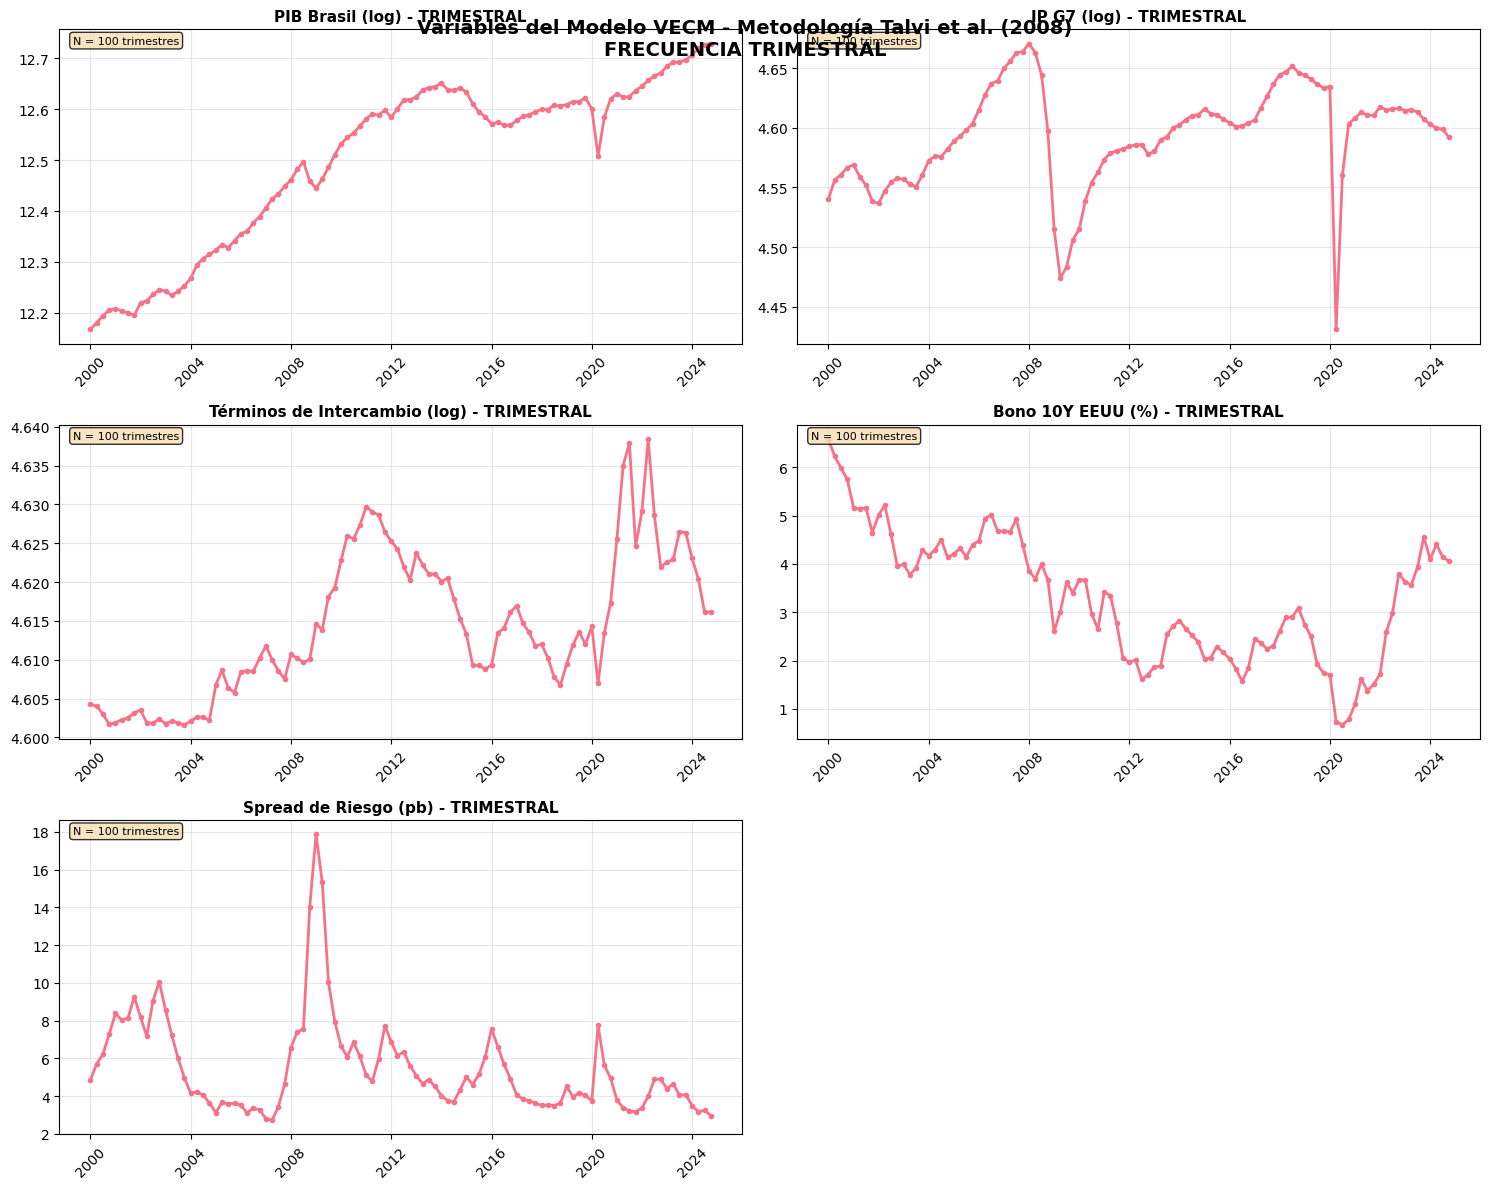


🔍 PASO 3: Pruebas de estacionariedad

=== PRUEBAS DE RAÍZ UNITARIA (DATOS TRIMESTRALES) ===

--- LOG_GDP ---
ADF Niveles: p-value = 0.8280 (Raíz unitaria)
ADF Diferencias: p-value = 0.0000 (Estacionaria)
KPSS Niveles: p-value = 0.0100
✅ log_gdp es I(1) - apropiado para VECM trimestral

--- LOG_IP_G7 ---
ADF Niveles: p-value = 0.0247 (Estacionaria)
ADF Diferencias: p-value = 0.0000 (Estacionaria)
KPSS Niveles: p-value = 0.1000
⚠️ log_ip_g7 podría ser I(0) - revisar especificación

--- LOG_TOT ---
ADF Niveles: p-value = 0.4834 (Raíz unitaria)
ADF Diferencias: p-value = 0.0000 (Estacionaria)
KPSS Niveles: p-value = 0.0225
✅ log_tot es I(1) - apropiado para VECM trimestral

--- US_10Y ---
ADF Niveles: p-value = 0.7546 (Raíz unitaria)
ADF Diferencias: p-value = 0.0000 (Estacionaria)
KPSS Niveles: p-value = 0.0100
✅ us_10y es I(1) - apropiado para VECM trimestral

--- RISK_SPREAD ---
ADF Niveles: p-value = 0.0051 (Estacionaria)
ADF Diferencias: p-value = 0.0000 (Estacionaria)
KPSS Niveles: 

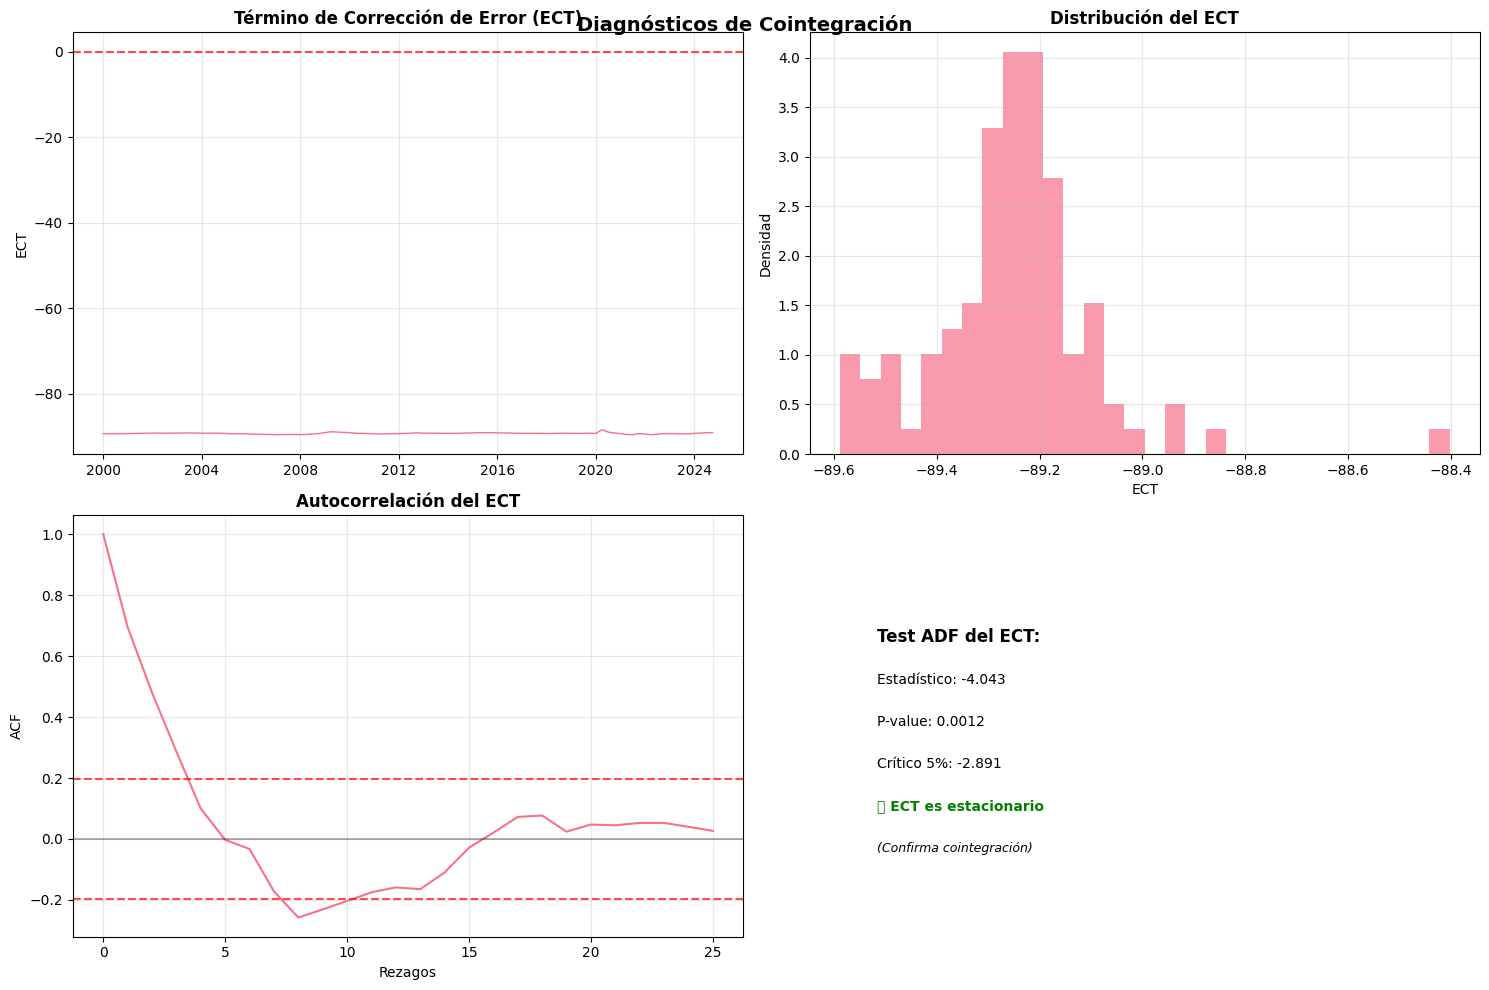


🎯 PASO 8: Interpretación económica detallada

🎯 INTERPRETACIÓN ECONÓMICA DETALLADA

🔍 ANÁLISIS DE LA RELACIÓN DE COINTEGRACIÓN:
Ecuación de equilibrio de largo plazo:
log(GDP) = 3.970*log(IP_G7) + 18.071*log(TOT) + 0.031*US_10Y + 0.006*RISK + C

📊 INTERPRETACIÓN POR VARIABLE:
------------------------------
🌍 PRODUCCIÓN INDUSTRIAL G7:
   • Coeficiente: 3.970
   • Un aumento del 1% en IP G7 → aumento del 4.0% en PIB Brasil (ESPERADO)

💰 TÉRMINOS DE INTERCAMBIO:
   • Coeficiente: 18.071
   • Un aumento del 1% en TOT → aumento del 18.1% en PIB Brasil (ESPERADO)

📈 BONO 10Y EEUU:
   • Coeficiente: 0.0312
   • Un aumento de 1pp en tasa → aumento del 3.12% en PIB Brasil (INESPERADO)

⚠️ SPREAD DE RIESGO:
   • Coeficiente: 0.0061
   • Un aumento de 1pp en spread → aumento del 0.61% en PIB Brasil (INESPERADO)

🚨 POSIBLES PROBLEMAS IDENTIFICADOS:
-----------------------------------
   ✅ Los signos son consistentes con la teoría económica


✅ ANÁLISIS COMPLETADO EXITOSAMENTE


In [20]:
# Crear instancia del modelo
modelo = TalviVECMModel()

# Ejecutar análisis completo
results = modelo.run_full_analysis(df_combined, gdp_brazil)

# Los resultados incluyen:
# - results['data']: Datos procesados
# - results['unit_root_results']: Pruebas de estacionariedad  
# - results['cointegration_results']: Resultados de cointegración
# - results['vecm_results']: Modelo VECM estimado
# - results['optimal_lags']: Número óptimo de rezagos


🔍 ANÁLISIS DIAGNÓSTICO DETALLADO

📊 MATRIZ DE CORRELACIONES:
             log_gdp  log_ip_g7  log_tot  us_10y  risk_spread
log_gdp        1.000      0.374    0.764  -0.702       -0.324
log_ip_g7      0.374      1.000    0.101  -0.106       -0.609
log_tot        0.764      0.101    1.000  -0.526       -0.187
us_10y        -0.702     -0.106   -0.526   1.000        0.062
risk_spread   -0.324     -0.609   -0.187   0.062        1.000

📈 ESTADÍSTICAS DESCRIPTIVAS:
        log_gdp  log_ip_g7   log_tot    us_10y  risk_spread
count  100.0000   100.0000  100.0000  100.0000     100.0000
mean    12.5009     4.5933    4.6143    3.2909       5.4624
std      0.1639     0.0423    0.0093    1.3112       2.5528
min     12.1672     4.4311    4.6016    0.6674       2.7218
25%     12.3589     4.5684    4.6074    2.2207       3.6903
50%     12.5796     4.6013    4.6134    3.3717       4.7168
75%     12.6230     4.6157    4.6219    4.2903       6.5799
max     12.7287     4.6704    4.6384    6.5902      17.8

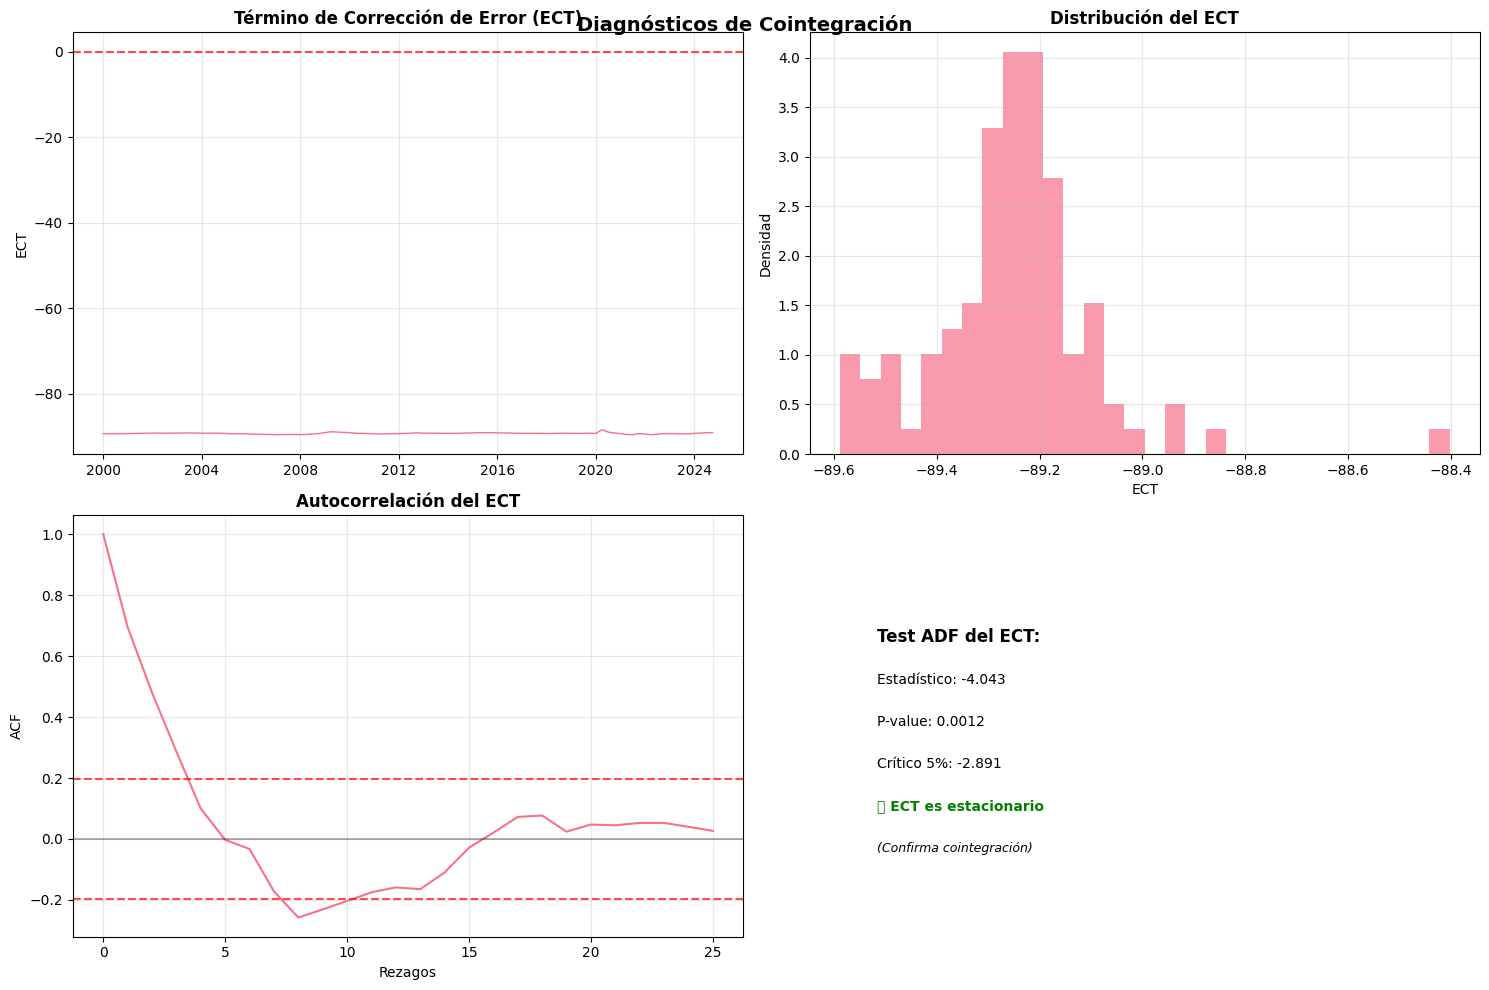

In [21]:
# Ejecutar diagnósticos adicionales
diagnostic_results = modelo.diagnostic_analysis()

# Ver correlaciones
print(diagnostic_results['correlations'])

# Análisis del término de corrección de error
ect = modelo.plot_cointegration_diagnostics()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class ExternalVulnerabilityFramework:
    """
    Framework para Indicadores de Vulnerabilidad Externa por País
    
    Combina múltiples metodologías para crear indicadores robustos de:
    1. Sensibilidad a factores externos
    2. Vulnerabilidad a shocks
    3. Capacidad de transmisión de crisis
    """
    
    def __init__(self):
        self.countries = {}
        self.vulnerability_indicators = {}
        self.external_factors = None
        self.methodology_results = {}
        
    def add_country(self, country_name, gdp_data, country_specific_data=None):
        """
        Añade un país al análisis
        
        Parameters:
        -----------
        country_name : str
        gdp_data : Series o DataFrame con PIB trimestral
        country_specific_data : dict con variables específicas del país
        """
        self.countries[country_name] = {
            'gdp': gdp_data,
            'specific_data': country_specific_data or {}
        }
        print(f"✅ País agregado: {country_name}")
    
    def set_external_factors(self, external_data):
        """
        Define las variables externas comunes
        
        Parameters:
        -----------
        external_data : DataFrame con variables externas trimestrales
        """
        self.external_factors = external_data
        print(f"✅ Factores externos configurados: {list(external_data.columns)}")
    
    # ===========================================
    # METODOLOGÍA 1: VECM INDIVIDUAL (Estilo Talvi)
    # ===========================================
    
    def estimate_vecm_by_country(self):
        """
        Estima VECM individual para cada país
        Extrae indicadores de vulnerabilidad
        """
        print("\n" + "="*60)
        print("📊 METODOLOGÍA 1: VECM INDIVIDUAL POR PAÍS")
        print("="*60)
        
        vecm_results = {}
        
        for country, data in self.countries.items():
            print(f"\n--- Estimando VECM para {country.upper()} ---")
            
            try:
                # Preparar datos
                country_data = self._prepare_country_data(country, data)
                
                if len(country_data) < 30:  # Mínimo para VECM
                    print(f"⚠️ Datos insuficientes para {country}")
                    continue
                
                # Estimar VECM
                vecm_model = VECM(country_data, k_ar_diff=2, coint_rank=1, deterministic='ci')
                vecm_fit = vecm_model.fit()
                
                # Extraer indicadores
                indicators = self._extract_vecm_indicators(vecm_fit)
                
                vecm_results[country] = {
                    'model': vecm_fit,
                    'indicators': indicators,
                    'data': country_data
                }
                
                print(f"✅ VECM estimado para {country}")
                
            except Exception as e:
                print(f"❌ Error en {country}: {e}")
                
        self.methodology_results['vecm'] = vecm_results
        return vecm_results
    
    def _prepare_country_data(self, country, data):
        """Prepara datos específicos del país para VECM"""
        # Combinar PIB del país con factores externos
        gdp_series = data['gdp']
        
        # Asegurar mismo período
        common_dates = gdp_series.index.intersection(self.external_factors.index)
        
        country_data = pd.DataFrame({
            'log_gdp': np.log(gdp_series.loc[common_dates]),
            'log_ip_g7': np.log(self.external_factors.loc[common_dates, 'ip_g7']),
            'log_tot': np.log(self.external_factors.loc[common_dates, 'tot']),
            'us_10y': self.external_factors.loc[common_dates, 'us_10y'],
            'risk_spread': self.external_factors.loc[common_dates, 'risk_spread']
        }).dropna()
        
        return country_data
    
    def _extract_vecm_indicators(self, vecm_fit):
        """Extrae indicadores de vulnerabilidad del VECM"""
        try:
            beta = vecm_fit.beta[:, 0] if vecm_fit.beta.ndim > 1 else vecm_fit.beta
            alpha = vecm_fit.alpha[:, 0] if vecm_fit.alpha.ndim > 1 else vecm_fit.alpha
            
            indicators = {
                # Sensibilidades (elasticidades)
                'ip_sensitivity': -beta[1],      # Sensibilidad a crecimiento global
                'tot_sensitivity': -beta[2],     # Sensibilidad a términos de intercambio
                'rate_sensitivity': -beta[3],    # Sensibilidad a tasas US
                'risk_sensitivity': -beta[4],    # Sensibilidad a spreads
                
                # Velocidad de ajuste
                'adjustment_speed': abs(alpha[0]),  # Qué tan rápido se ajusta
                
                # Indicador compuesto
                'vulnerability_score': abs(beta[1]) + abs(beta[2]) + abs(beta[3]) + abs(beta[4])
            }
            
            return indicators
            
        except Exception as e:
            print(f"Error extrayendo indicadores: {e}")
            return {}
    
    # ===========================================
    # METODOLOGÍA 2: CORRELACIONES DINÁMICAS
    # ===========================================
    
    def estimate_dynamic_correlations(self, window=20):
        """
        Calcula correlaciones móviles entre PIB país y factores externos
        """
        print("\n" + "="*60)
        print("📈 METODOLOGÍA 2: CORRELACIONES DINÁMICAS")
        print("="*60)
        
        dynamic_results = {}
        
        for country, data in self.countries.items():
            print(f"\n--- Correlaciones dinámicas para {country.upper()} ---")
            
            try:
                country_data = self._prepare_country_data(country, data)
                
                if len(country_data) < window + 10:
                    print(f"⚠️ Datos insuficientes para {country}")
                    continue
                
                # Calcular correlaciones móviles
                rolling_corrs = {}
                gdp_growth = country_data['log_gdp'].diff()
                
                for factor in ['log_ip_g7', 'log_tot', 'us_10y', 'risk_spread']:
                    if factor.startswith('log_'):
                        factor_data = country_data[factor].diff()
                    else:
                        factor_data = country_data[factor].diff()
                    
                    rolling_corr = gdp_growth.rolling(window).corr(factor_data)
                    rolling_corrs[factor] = rolling_corr
                
                # Indicadores de vulnerabilidad
                indicators = self._extract_correlation_indicators(rolling_corrs)
                
                dynamic_results[country] = {
                    'rolling_correlations': rolling_corrs,
                    'indicators': indicators
                }
                
                print(f"✅ Correlaciones calculadas para {country}")
                
            except Exception as e:
                print(f"❌ Error en {country}: {e}")
        
        self.methodology_results['dynamic_corr'] = dynamic_results
        return dynamic_results
    
    def _extract_correlation_indicators(self, rolling_corrs):
        """Extrae indicadores de las correlaciones dinámicas"""
        indicators = {}
        
        for factor, corr_series in rolling_corrs.items():
            corr_clean = corr_series.dropna()
            if len(corr_clean) > 0:
                indicators[f'{factor}_avg_corr'] = corr_clean.mean()
                indicators[f'{factor}_vol_corr'] = corr_clean.std()
                indicators[f'{factor}_max_corr'] = corr_clean.abs().max()
        
        # Indicador compuesto de vulnerabilidad
        if indicators:
            avg_corrs = [v for k, v in indicators.items() if 'avg_corr' in k]
            indicators['overall_vulnerability'] = np.mean([abs(c) for c in avg_corrs])
        
        return indicators
    
    # ===========================================
    # METODOLOGÍA 3: ANÁLISIS DE COMPONENTES PRINCIPALES
    # ===========================================
    
    def estimate_pca_vulnerability(self):
        """
        Usa PCA para identificar factores comunes de vulnerabilidad
        """
        print("\n" + "="*60)
        print("🔍 METODOLOGÍA 3: ANÁLISIS PCA DE VULNERABILIDAD")
        print("="*60)
        
        # Construir matriz de todas las series de PIB
        all_gdp_data = {}
        
        for country, data in self.countries.items():
            gdp_growth = np.log(data['gdp']).diff().dropna()
            all_gdp_data[country] = gdp_growth
        
        if len(all_gdp_data) < 2:
            print("⚠️ Se necesitan al menos 2 países para PCA")
            return {}
        
        # Crear DataFrame común
        gdp_df = pd.DataFrame(all_gdp_data).dropna()
        
        if len(gdp_df) < 20:
            print("⚠️ Datos insuficientes para PCA")
            return {}
        
        # Aplicar PCA
        scaler = StandardScaler()
        gdp_scaled = scaler.fit_transform(gdp_df)
        
        pca = PCA()
        pca_result = pca.fit_transform(gdp_scaled)
        
        # Extraer indicadores
        pca_indicators = {
            'explained_variance': pca.explained_variance_ratio_,
            'components': pca.components_,
            'countries': list(gdp_df.columns),
            'factor_loadings': pd.DataFrame(
                pca.components_[:3].T,  # Primeros 3 componentes
                columns=['PC1', 'PC2', 'PC3'],
                index=gdp_df.columns
            )
        }
        
        self.methodology_results['pca'] = pca_indicators
        print(f"✅ PCA completado para {len(gdp_df.columns)} países")
        
        return pca_indicators
    
    # ===========================================
    # METODOLOGÍA 4: STRESS TESTING
    # ===========================================
    
    def stress_testing(self, shock_scenarios):
        """
        Simula impactos de shocks externos en cada país
        
        Parameters:
        -----------
        shock_scenarios : dict
            Ej: {'oil_shock': {'tot': -0.2, 'risk_spread': 2.0}}
        """
        print("\n" + "="*60)
        print("🚨 METODOLOGÍA 4: STRESS TESTING")
        print("="*60)
        
        stress_results = {}
        
        # Usar resultados VECM si están disponibles
        if 'vecm' not in self.methodology_results:
            print("⚠️ Ejecutar estimate_vecm_by_country() primero")
            return {}
        
        for country, vecm_data in self.methodology_results['vecm'].items():
            print(f"\n--- Stress Testing para {country.upper()} ---")
            
            country_stress = {}
            indicators = vecm_data['indicators']
            
            for scenario_name, shocks in shock_scenarios.items():
                total_impact = 0
                
                # Calcular impacto total del escenario
                if 'ip_g7' in shocks:
                    total_impact += indicators.get('ip_sensitivity', 0) * shocks['ip_g7']
                if 'tot' in shocks:
                    total_impact += indicators.get('tot_sensitivity', 0) * shocks['tot']
                if 'us_10y' in shocks:
                    total_impact += indicators.get('rate_sensitivity', 0) * shocks['us_10y']
                if 'risk_spread' in shocks:
                    total_impact += indicators.get('risk_sensitivity', 0) * shocks['risk_spread']
                
                country_stress[scenario_name] = {
                    'gdp_impact_pct': total_impact,
                    'severity': 'Alto' if abs(total_impact) > 5 else 'Medio' if abs(total_impact) > 2 else 'Bajo'
                }
            
            stress_results[country] = country_stress
            print(f"✅ Stress testing completado para {country}")
        
        self.methodology_results['stress_test'] = stress_results
        return stress_results
    
    # ===========================================
    # CONSOLIDACIÓN DE INDICADORES
    # ===========================================
    
    def create_vulnerability_dashboard(self):
        """
        Consolida todos los indicadores en un dashboard
        """
        print("\n" + "="*60)
        print("📊 DASHBOARD DE VULNERABILIDAD EXTERNA")
        print("="*60)
        
        dashboard = {}
        
        for country in self.countries.keys():
            country_indicators = {'country': country}
            
            # VECM indicators
            if 'vecm' in self.methodology_results and country in self.methodology_results['vecm']:
                vecm_ind = self.methodology_results['vecm'][country]['indicators']
                country_indicators.update({
                    'tot_elasticity': vecm_ind.get('tot_sensitivity', np.nan),
                    'ip_elasticity': vecm_ind.get('ip_sensitivity', np.nan),
                    'adjustment_speed': vecm_ind.get('adjustment_speed', np.nan),
                    'overall_sensitivity': vecm_ind.get('vulnerability_score', np.nan)
                })
            
            # Dynamic correlation indicators
            if 'dynamic_corr' in self.methodology_results and country in self.methodology_results['dynamic_corr']:
                dyn_ind = self.methodology_results['dynamic_corr'][country]['indicators']
                country_indicators.update({
                    'correlation_vulnerability': dyn_ind.get('overall_vulnerability', np.nan)
                })
            
            # PCA indicators
            if 'pca' in self.methodology_results:
                pca_data = self.methodology_results['pca']
                if country in pca_data['countries']:
                    idx = pca_data['countries'].index(country)
                    country_indicators.update({
                        'common_factor_loading': abs(pca_data['components'][0, idx])
                    })
            
            dashboard[country] = country_indicators
        
        self.vulnerability_indicators = dashboard
        
        # Crear DataFrame para visualización
        dashboard_df = pd.DataFrame(list(dashboard.values()))
        
        print("\n📋 RESUMEN DE INDICADORES:")
        print(dashboard_df.round(3))
        
        return dashboard_df
    
    def plot_vulnerability_comparison(self):
        """
        Genera gráficos comparativos de vulnerabilidad
        """
        if not self.vulnerability_indicators:
            print("⚠️ Ejecutar create_vulnerability_dashboard() primero")
            return
        
        dashboard_df = pd.DataFrame(list(self.vulnerability_indicators.values()))
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Sensibilidad a términos de intercambio
        if 'tot_elasticity' in dashboard_df.columns:
            dashboard_df.set_index('country')['tot_elasticity'].plot(kind='bar', ax=axes[0,0])
            axes[0,0].set_title('Sensibilidad a Términos de Intercambio', fontweight='bold')
            axes[0,0].set_ylabel('Elasticidad')
        
        # 2. Sensibilidad a crecimiento global
        if 'ip_elasticity' in dashboard_df.columns:
            dashboard_df.set_index('country')['ip_elasticity'].plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('Sensibilidad a Crecimiento Global', fontweight='bold')
            axes[0,1].set_ylabel('Elasticidad')
        
        # 3. Velocidad de ajuste
        if 'adjustment_speed' in dashboard_df.columns:
            dashboard_df.set_index('country')['adjustment_speed'].plot(kind='bar', ax=axes[1,0])
            axes[1,0].set_title('Velocidad de Ajuste', fontweight='bold')
            axes[1,0].set_ylabel('Coeficiente Alpha')
        
        # 4. Vulnerabilidad general
        if 'overall_sensitivity' in dashboard_df.columns:
            dashboard_df.set_index('country')['overall_sensitivity'].plot(kind='bar', ax=axes[1,1])
            axes[1,1].set_title('Vulnerabilidad General', fontweight='bold')
            axes[1,1].set_ylabel('Score Compuesto')
        
        plt.tight_layout()
        plt.suptitle('COMPARACIÓN DE VULNERABILIDAD EXTERNA POR PAÍS', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.show()
    
    def generate_risk_report(self, country_name):
        """
        Genera reporte de riesgo específico para un país
        """
        if country_name not in self.vulnerability_indicators:
            print(f"❌ No hay datos para {country_name}")
            return
        
        indicators = self.vulnerability_indicators[country_name]
        
        print("\n" + "="*60)
        print(f"📊 REPORTE DE RIESGO EXTERNO - {country_name.upper()}")
        print("="*60)
        
        print(f"\n🎯 INDICADORES CLAVE:")
        print(f"{'Sensibilidad TOT:':<25} {indicators.get('tot_elasticity', 'N/A')}")
        print(f"{'Sensibilidad IP Global:':<25} {indicators.get('ip_elasticity', 'N/A')}")
        print(f"{'Velocidad Ajuste:':<25} {indicators.get('adjustment_speed', 'N/A')}")
        print(f"{'Vulnerabilidad General:':<25} {indicators.get('overall_sensitivity', 'N/A')}")
        
        # Clasificación de riesgo
        tot_sens = indicators.get('tot_elasticity', 0)
        if abs(tot_sens) > 15:
            risk_level = "🔴 ALTO"
        elif abs(tot_sens) > 8:
            risk_level = "🟡 MEDIO"
        else:
            risk_level = "🟢 BAJO"
        
        print(f"\n🚨 NIVEL DE RIESGO: {risk_level}")
        
        # Stress test results si están disponibles
        if 'stress_test' in self.methodology_results and country_name in self.methodology_results['stress_test']:
            print(f"\n📊 STRESS TEST RESULTS:")
            stress_data = self.methodology_results['stress_test'][country_name]
            for scenario, results in stress_data.items():
                print(f"  {scenario}: {results['gdp_impact_pct']:.1f}% PIB ({results['severity']} impacto)")

# ===========================================
# EJEMPLO DE USO COMPLETO
# ===========================================

def create_vulnerability_system():
    """
    Ejemplo de cómo usar el framework completo
    """
    
    # Inicializar framework
    vuln_framework = ExternalVulnerabilityFramework()
    
    print("🚀 SISTEMA DE INDICADORES DE VULNERABILIDAD EXTERNA")
    print("="*60)
    print("Este framework permite:")
    print("✅ Estimar vulnerabilidad por país")
    print("✅ Comparar países entre sí")
    print("✅ Realizar stress testing")
    print("✅ Generar reportes de riesgo")
    
    return vuln_framework

# Para usar:
# framework = create_vulnerability_system()
# framework.add_country('Brasil', gdp_brazil_data)
# framework.add_country('Mexico', gdp_mexico_data)  # cuando tengas más países
# framework.set_external_factors(external_factors_df)
# framework.estimate_vecm_by_country()
# framework.estimate_dynamic_correlations()
# framework.stress_testing({'crisis_scenario': {'tot': -0.2, 'risk_spread': 3.0}})
# dashboard = framework.create_vulnerability_dashboard()
# framework.plot_vulnerability_comparison()
# framework.generate_risk_report('Brasil')

ImportError: cannot import name 'coint_johansen' from 'statsmodels.tsa.stattools' (c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\statsmodels\tsa\stattools.py)

In [23]:
# Implementar el framework con Brasil
framework = create_vulnerability_system()
framework.add_country('Brasil', gdp_brazil)
framework.set_external_factors(df_external_trimestral)

# Ejecutar todas las metodologías
results = framework.estimate_vecm_by_country()
framework.estimate_dynamic_correlations()
framework.stress_testing({
    'commodity_crash': {'tot': -0.3, 'risk_spread': 4.0},
    'global_recession': {'ip_g7': -0.1, 'us_10y': 2.0},
    'financial_crisis': {'risk_spread': 5.0, 'us_10y': 1.5}
})

# Generar dashboard
dashboard = framework.create_vulnerability_dashboard()
framework.generate_risk_report('Brasil')

🚀 SISTEMA DE INDICADORES DE VULNERABILIDAD EXTERNA
Este framework permite:
✅ Estimar vulnerabilidad por país
✅ Comparar países entre sí
✅ Realizar stress testing
✅ Generar reportes de riesgo
✅ País agregado: Brasil


NameError: name 'df_external_trimestral' is not defined